# Forward Modelling and 1D Sounding of the Left Boundary of the Model

In [66]:
import numpy as np
import os
from matplotlib import pyplot as plt

from SimPEG import maps
from SimPEG.electromagnetics import frequency_domain as fdem
from SimPEG.utils import plot_1d_layer_model

In [67]:
write_output = True

## Create Survey

The survey consists of a vertical magnetic dipole source operating at 15 frequencies. Real and imaginary data in Tesla are measured by a vertically-oriented reciever coil offset 10 m from the source.

In [68]:
# Frequencies being observed in Hz
frequencies = np.logspace(-1, 4, 15)

# Defining the z-locations of all sources and recievers as flight heights.

# Source properties
source_location = np.array([0.0, 0.0, 30.0])  # (3, ) numpy.array_like
source_orientation = "z"  # "x", "y" or "z"
moment = 1.0  # dipole moment in Am^2

# Receiver properties
receiver_location = np.array([10.0, 0.0, 30.0]) # 10 m offset in x direction
receiver_orientation = "z"  # "x", "y" or "z"

In [69]:
# Define a list of receivers. The real and imaginary components are defined
# as separate receivers.
receiver_list = []
receiver_list.append(
    fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_location,
        orientation=receiver_orientation,
        component="real",
    )
)
receiver_list.append(
    fdem.receivers.PointMagneticFluxDensitySecondary(
        receiver_location,
        orientation=receiver_orientation,
        component="imag",
    )
)

# Define the source list. A source must be defined for each frequency.
source_list = []
for freq in frequencies:
    source_list.append(
        fdem.sources.MagDipole(
            receiver_list=receiver_list,
            frequency=freq,
            location=source_location,
            orientation=source_orientation,
            moment=moment,
        )
    )

# Define a 1D FDEM survey
survey = fdem.survey.Survey(source_list)

In [70]:
# Define layer thicknesses (m)
layer_thicknesses = np.array([500.0])

# Define layer conductivities (S/m)
layer_resistivities = np.r_[1000, 100]

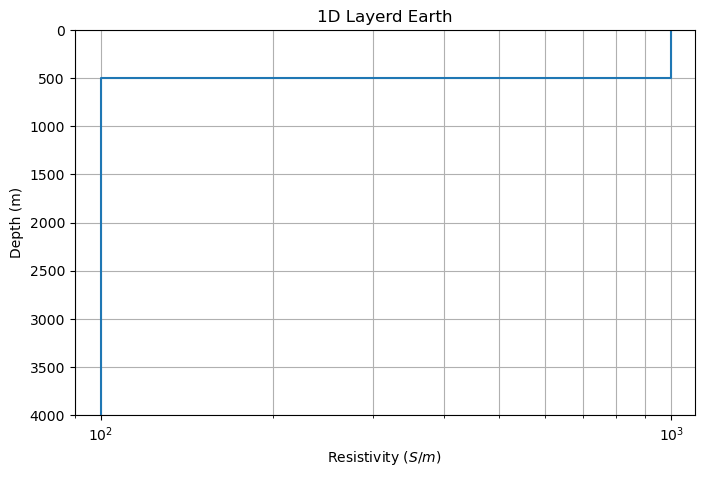

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax = plot_1d_layer_model(layer_thicknesses, layer_resistivities, scale="log", ax=ax)
ax.grid(which="both")
ax.set_xlabel(r"Resistivity ($S/m$)")
ax.set_ylim([4000, 0])
ax.set_title("1D Layerd Earth")
plt.show()

## Define the Model

For this project I will be using a Log-resistivity model with fixed magnetic permeability

In [72]:
# LOG-RESISTIVITY MODEL
log_resistivity_model = np.log(layer_resistivities)

# Define the Mappings
log_resistivity_map = maps.ExpMap(nP=len(layer_thicknesses)+1)

## Define the Forward Simulation

In [73]:
simulation= fdem.Simulation1DLayered(
    survey=survey,
    thicknesses=layer_thicknesses,
    rhoMap=log_resistivity_map,
)

## Predict 1D FDEM Data

In [74]:
dpred= simulation.dpred(log_resistivity_model)

Following is the plot of absolute values of the collected data in log scale. The data collected are the z-component of the secondary magnetic field.

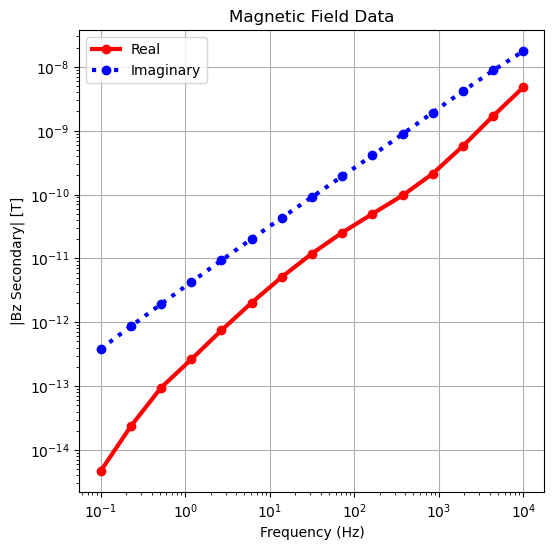

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.loglog(frequencies, abs(dpred[0::2]), "r-o", lw=3)
ax.loglog(frequencies, abs(dpred[1::2]), "b:o", lw=3)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("|Bz Secondary| [T]")
ax.set_title("Magnetic Field Data")
ax.legend(["Real", "Imaginary"])
plt.grid()

plt.show()

In [76]:
if write_output:
    # Get the directory of the current notebook
    notebook_dir = os.getcwd()
    dir_path = os.path.join(notebook_dir, "1d_simulation_data")
    
    # Ensure the directory exists, create it if not
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    np.random.seed(222)
    noise_level = 0.05 
    noise = noise_level * np.abs(dpred) * np.random.rand(len(dpred))
    dobs = dpred + noise

    fname = os.path.join(dir_path, "em1dfm_data_left.txt")
    np.savetxt(
        fname,
        np.c_[frequencies, dobs[0::2], dobs[1::2]],
        fmt="%.4e",
        header="FREQUENCY HZ_REAL HZ_IMAG",
    )